# Классификация рукописных цифр

### Метод ближайших соседей

### Сверточная нейросеть

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from source.torchutils import ModelWithAPI, Flatten, Softmax
import matplotlib.pyplot as plt

In [3]:
# mnist_loader.py
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
import torch
import PIL
import numpy as np

from albumentations import Compose, HorizontalFlip, Cutout, ShiftScaleRotate, ToGray, ToFloat, Transpose
from albumentations.pytorch import ToTensor

mnist_dataset_train = MNIST('./mnist/', train=True, download=True)
mnist_dataset_test = MNIST('./mnist/', train=False, download=True)


class MNIST_Dataset(Dataset):
    def __init__(self, train=True, trs=None, size=1.0):
        global mnist_dataset
        self.train = train
        
        if self.train:
            self.data = mnist_dataset_train.train_data.numpy()
            self.N = len(self.data)
            self.targets = mnist_dataset_train.train_labels.numpy()
        else:
            self.data = mnist_dataset_test.test_data.numpy()
            self.N = len(self.data)
            self.targets = mnist_dataset_test.test_labels.numpy()
            
        self.N = int(self.N * size) 
        self.data = self.data[:self.N]
        self.targets = self.targets[:self.N]
        
        if trs is None:
            self.trs = Compose([Transpose(always_apply=True), ToTensor()])
        else:
            self.trs = trs
            
        
    def __len__(self):
        return self.N
    
    
    def __getitem__(self, idx):
        x = self.data[idx]
        x = self.trs(image=x)['image']
        x = torch.unsqueeze(x, 0)
        
        y = self.targets[idx]
        
        return x, y
    

def create_mnist_loader(train=True, trs=None, batch_size=256, size=1.0, num_workers=0):
    dataset = MNIST_Dataset(train=train, trs=trs, size=size)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    
    return loader

In [127]:
aug_trs = Compose([ShiftScaleRotate(shift_limit=0.1, 
                                    scale_limit=0.3, 
                                    rotate_limit=45, 
                                    p=0.5),
                   Cutout(num_holes=32, max_h_size=3, max_w_size=3, p=0.5),
                   Transpose(always_apply=True),
                   ToTensor()])

In [128]:
train_loader = create_mnist_loader(size=0.3, trs = aug_trs)
test_loader = create_mnist_loader(train=False, size=0.2)

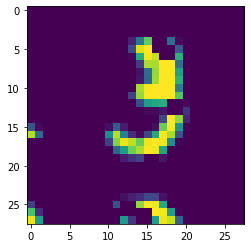

In [133]:
for x, y in train_loader:
    plt.imshow(x[10][0])
    break

In [134]:
conv_net = torch.nn.Sequential(torch.nn.Conv2d(1, 16, 3, stride=2, padding=3),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(16),
                               # 16x16x16
                               
                               torch.nn.Conv2d(16, 32, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(32),
                               # 8x8x32
                               
                               torch.nn.Conv2d(32, 64, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(64),
                               # 4x4x64
                               
                               torch.nn.Conv2d(64, 128, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(128),
                               # 2x2x64
                               
                               Flatten(),
                               torch.nn.Linear(512, 10), 
                               Softmax())

optim = torch.optim.Adam(conv_net.parameters(), 5e-3)
criterion = torch.nn.functional.cross_entropy

In [135]:
model = ModelWithAPI(conv_net, optim, criterion, device='cpu')

In [136]:
model.model = torch.load('cnn_model.pt')

In [ ]:
train_history, val_history = model.fit_loader(train_loader, 
                                              val_loader=test_loader, 
                                              epochs=30, 
                                              lr_decay_every=10);

A Jupyter Widget

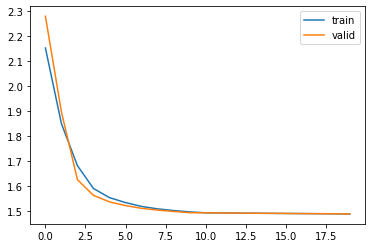

In [24]:
plt.plot(train_history, label='train')
plt.plot(val_history, label='valid')
plt.legend()
plt.show()

In [8]:
pred = model.evaluate_metrics_loader(test_loader)

In [9]:
pred[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [10]:
(pred == test_loader.dataset.targets).mean()

0.9435

In [11]:
# torch.save(model.model, './cnn_model.pt')

In [12]:
%matplotlib inline

In [13]:
import cv2

In [21]:
img = PIL.Image.open('./tmp.png')
# img = img.resize((28, 28))
arr = np.asarray(img)
arr = cv2.resize(arr, (28, 28), interpolation=cv2.INTER_AREA)
arr = arr / arr.max()

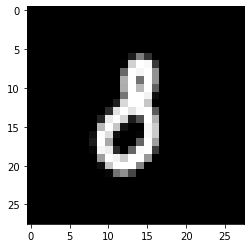

In [22]:
plt.imshow(arr)

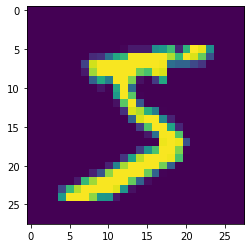

In [19]:
plt.imshow(train_loader.dataset.data[0])

In [9]:
score = model.predict_score_loader(test_loader)

In [13]:
with torch.no_grad():
    score = torch.nn.Softmax(dim=1)(score)

In [41]:
import PIL

def predict_img(model, img_path, device='cpu'):
    img = PIL.Image.open(img_path)
    img = img.resize((28, 28))
    arr = np.asarray(img)
    arr = arr / arr.max()
    
    if len(arr.shape) > 2:
        arr = arr[..., 0] # rgb to gray
        
    t = torch.Tensor(arr.reshape((1, 1) + arr.shape))
    
    model = model.to(device)
    model.eval()
    score = None
    with torch.no_grad():
        score = model(t.to(device))
        
    score = score.to('cpu').numpy()[0]
    return score.argmax()

In [42]:
predict_img(model.model, 'tmp.png')

/Users/timur89833239972/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


6

In [ ]:
trs = Compose([ShiftScaleRotate(shift_limit=0.05, 
                                                 scale_limit=0.05, 
                                                 rotate_limit=180, 
                                                 p=0.5),
                                ToTensor()])